In [1]:
import ssl
import numbers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

%config Completer.use_jedi = False

ssl._create_default_https_context = ssl._create_unverified_context


def get_mape(y_predict, y_true):
    return (abs(y_predict - y_true) / y_true).mean()

def process_rooms_number(x):
        
    if pd.isna(x):
        return 1
    
    if isinstance(x, int):
        return x
    
    if x.isdigit():
        return int(x)
    
    if x == 'Студия':
        return 1
    
    if x == 'Своб. планировка':
        return 1
    
    if x == '> 9':
        return 10

    return 1

<h3>Реализуем линейную регрессию</h3>

<p>Чаще всего алгоритмы машинного обучения реализуются в виде классов с обязательными методами <code>.fit()</code>, <code>.predict()</code>. </p>

<p><code>.fit()</code> – обучить алгоритм на обучающей выборке;</p>

<p><code>.predict()</code> – сделать предсказание на тестовых данных.</p>

<p> </p>

In [9]:
class LinearRegression:
    
    def __init__(self, max_iter=1e4, lr=0.001, tol=0.001, print_every=100):
        
        self.max_iter = max_iter
        self.lr = lr
        self.tol = tol
        self.print_every = print_every
        
        self.weights = None
        self.bias = None
        
    def fit(self, X_train, y_train, X_val, y_val):
        
        self.check_regression_X_y(X_train, y_train)
        self.check_regression_X_y(X_val, y_val)
        
        n, m = X_train.shape
        
        self.weights = np.zeros((m, 1))
        self.bias = np.median(y_train)
        
        n_iter = 0
        gradient_norm = np.inf
        
        while n_iter < self.max_iter and gradient_norm > self.tol:
            dJdw, dJdb = self.grads(X_train, y_train)
                
            gradient_norm = np.linalg.norm(np.hstack([dJdw.flatten(), [dJdb]]))
                
            self.weights = self.weights - self.lr * dJdw
            self.bias = self.bias - self.lr * dJdb
            
            n_iter += 1
            
            if n_iter % self.print_every == 0:
                self.print_metrics(X_train, y_train, X_val, y_val, n_iter, gradient_norm)
        
        return self

    def predict(self, X):
        return X @ self.weights + self.bias
    
    def grads(self, X, y):
        y_hat = self.predict(X)
        
        dJdw = 2 * (X.T @ (y - y_hat)) / len(X)
        dJdb = 2 * (y - y_hat).mean()
        
        self.check_grads(dJdw, dJdb)
        
        return dJdw, dJdb
    
    def print_metrics(self, X_train, y_train, X_val, y_val, n_iter, gradient_norm):
        
        train_preds = self.predict(X_train)
        val_preds = self.predict(X_val)
        
        MAPE_train = get_mape(train_preds, y_train)
        MAPE_val = get_mape(val_preds, y_val)
        
        print(f'{n_iter} completed. MAPE on train: {MAPE_train}, val: {MAPE_val},  grad norm: {gradient_norm}')
        
        
    def check_grads(self, dJdw, dJdb):
        
        if not isinstance(dJdb, numbers.Real):
            raise ValueError(f'Производная по параметру b должна быть действительным '
                             f'числом, как и сам параметр b, а у нас {dJdb} типа {type(dJdb)}')
            
        if dJdw.shape != self.weights.shape:
            raise ValueError(f'Размерность градиента по параметрам w должна совпадать с самим вектором w, '
                             f'а у нас dJdw.shape = {dJdw.shape} не совпадает с weight.shape = {self.weights.shape}')
            
        
    @staticmethod
    def check_regression_X_y(X, y):
        
        if X.shape[0] == 0:
            raise ValueError(f'X и y не должны быть пустыми, а у нас X.shape = {X.shape} и y.shape = {y.shape}')
            
        if np.isnan(X).any():
            raise ValueError(f'X не должен содержать "not a number" (np.nan)')
            
        if np.isnan(y).any():
            raise ValueError(f'y не должен содержать "not a number" (np.nan)')
        
        if X.shape[0] != y.shape[0]:
            raise ValueError(f'Длина X и y должна быть одинаковой, а у нас X.shape = {X.shape}, y.shape = {y.shape}')
            
        if y.shape[1] != 1:
            raise ValueError(f'y - вектор ответов должен быть размерности (m, 1), а у нас y.shape = {y.shape}')
                    
        if np.any([(not isinstance(value, numbers.Real)) for value in y.flatten()]):
            raise ValueError(f'Ответы на объектах должны быть действительными числами!')
       

<h3>Тестируем модель на простой задаче</h3>

In [10]:
X = np.array([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1],
    [1, 1, 1],
])
y = np.array([[1], [2], [3], [4]])
model = LinearRegression(lr=0.1)
model.fit(X, y, X, y)
model.predict(X)

100 completed. MAPE on train: 6155844252290.813, val: 6155844252290.813,  grad norm: 26474050542701.258
200 completed. MAPE on train: 3.654498472642654e+26, val: 3.654498472642654e+26,  grad norm: 1.571667074529458e+27
300 completed. MAPE on train: 2.169541420987484e+40, val: 2.169541420987484e+40,  grad norm: 9.33040975039231e+40
400 completed. MAPE on train: 1.2879769994750372e+54, val: 1.2879769994750372e+54,  grad norm: 5.5391213267148074e+54
500 completed. MAPE on train: 7.64624604595779e+67, val: 7.64624604595779e+67,  grad norm: 3.2883727395548445e+68
600 completed. MAPE on train: 4.539295237349328e+81, val: 4.539295237349328e+81,  grad norm: 1.9521860303176892e+82
700 completed. MAPE on train: 2.6948127392153814e+95, val: 2.6948127392153814e+95,  grad norm: 1.1589410929989182e+96
800 completed. MAPE on train: 1.599811274597352e+109, val: 1.599811274597352e+109,  grad norm: 6.880207296755176e+109
900 completed. MAPE on train: 9.497491521707706e+122, val: 9.497491521707706e+122, 

/var/folders/k3/57cvqk9113964s_8bqbv05mh0000gq/T/ipykernel_5380/3207333840.py:47: RuntimeWarning: overflow encountered in multiply
  dJdw = 2 * (X.T @ (y - y_hat)) / len(X)
/Users/a.safronov/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/var/folders/k3/57cvqk9113964s_8bqbv05mh0000gq/T/ipykernel_5380/3207333840.py:42: RuntimeWarning: invalid value encountered in matmul
  return X @ self.weights + self.bias


array([[nan],
       [nan],
       [nan],
       [nan]])

<h3>Решаем задачу предсказания цены</h3>

In [44]:
data = pd.read_csv('real_estate_novosibirsk.csv')

In [ ]:
from sk

In [35]:
train, val, train_price, val_price = train_test_split(data.drop('price', axis=1), data['price'], random_state=42)

In [32]:
train['min_floor_district'] = 0
train['max_floor_district'] = 0
val['min_floor_district'] = 0
val['max_floor_district'] = 0
for d in train['district'].unique():
    subsample = train.loc[data['district'] == d, 'floor']
    
    
    train.loc[subsample[subsample == subsample.min()].index, 'min_floor_district'] = 1
    data.loc[subsample[subsample == subsample.max()].index, 'max_floor_district'] = 1

In [38]:
data.max_floor_district.value_counts()

0    36914
1       48
Name: max_floor_district, dtype: int64

<p>Чистим данные:</p>

In [14]:
data = data.drop_duplicates(subset=['item_id'], keep='last')
data = data.dropna(subset=['area'])
data['rooms_number'] = data['rooms_number'].apply(process_rooms_number).copy()
data = data[(data.price > 970000) & (data.price < 12700000)]
data = data[(data.floor < 59)]

data = data.dropna(axis=0)

In [15]:
train, val, train_price, val_price = train_test_split(data.drop('price', axis=1), data['price'], random_state=42)

In [16]:
test_data = pd.read_csv('test_price_estimator.csv')
test, test_price = test_data.drop('price', axis=1), test_data['price']

y_train = train_price.values.reshape(-1, 1)
y_val = val_price.values.reshape(-1, 1)

### Делаем бейзлайн

In [ ]:
get_mape(y_predict=np.median(y_train), y_true=y_val)

### Обучаем модель

1) Начинаем с простого

In [ ]:
X_train = train[['area']].values
X_val = val[['area']].values


model = LinearRegression(lr=6e-4, max_iter=140000, print_every=10000, tol=0.1)
model.fit(X_train, y_train, X_val, y_val)

<p>Для того, чтобы начать ориентироваться в метрике решения задачи, очень важно построить одну или несколько простых моделей. Часто есть соблазн добавить все признаки сразу и обучить модель — мы так поступать не будем. Наоборот, мы будем постепенно добавлять признаки и следить за тем, что модель решает задачу лучше и лучше. </p>

2) Увеличиваем количество признаков

<AxesSubplot:ylabel='Frequency'>

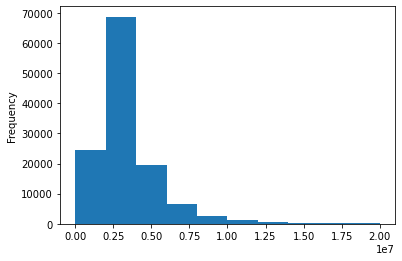

In [54]:
data[data['price'] < 20000000]['price'].plot(kind='hist')

<AxesSubplot:xlabel='area'>

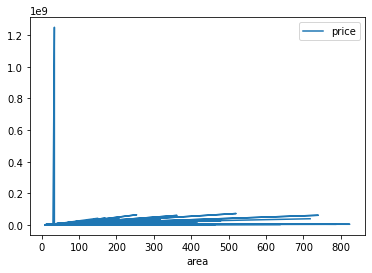

In [51]:
data[['area', 'price']].set_index('area').plot()

In [ ]:
X_train = train[['area', 'floors_in_house', 'floor']].values
X_val = val[['area', 'floors_in_house', 'floor']].values

model = LinearRegression(lr=6e-4, max_iter=120000, print_every=10000, tol=0.1)
model.fit(X_train, y_train, X_val, y_val)

Делаем новые признаки
##### One hot encoding

In [ ]:
ohe_example = pd.DataFrame({'feature': ['a', 'b', 'a', 'c']})
ohe_example

In [ ]:
ohe = OneHotEncoder(sparse=False)
ohe.fit_transform(ohe_example)

In [11]:
ohe_house_type_transformer = OneHotEncoder(sparse=False)
train_ohe_house_type = ohe_house_type_transformer.fit_transform(train[['type_of_house']])
val_ohe_house_type = ohe_house_type_transformer.transform(val[['type_of_house']])

ohe_district_transformer = OneHotEncoder(sparse=False)
train_ohe_district = ohe_district_transformer.fit_transform(train[['district']])
val_ohe_district = ohe_district_transformer.transform(val[['district']])

X_train_extended = np.hstack([X_train, train_ohe_house_type, train_ohe_district])
X_val_extended = np.hstack([X_val, val_ohe_house_type, val_ohe_district])

model = LinearRegression(lr=6e-4, max_iter=120000, print_every=10000, tol=0.1)
model.fit(X_train_extended, y_train, X_val_extended, y_val)

NameError: name 'train' is not defined

### Задание на семинаре: попробовать улучшить метрику MAPE до 15.8% (топ-1 без ML с первой недели).

Варианты путей для улучшения:

    1) Делать новые признаки из существующих;
    2) Препроцессинг данных, целевой переменной - постпроцессинг ответов модели;
    3) Анализ ошибок модели –> генерация идей;
    4) Добавить регуляризацию;


<h3>Задание на семинаре: реализуем логистическую регрессию</h3>

<p>Мы получаем оптимальные веса алгоритма градиентным спуском:</p>

<p style="text-align:center"><br />
<br />
<span class="math-tex">\(\begin{bmatrix} w_{1}^{t+1}\\  ...\\ w_{m}^{t+1}\\  \end{bmatrix} = \begin{bmatrix} w_{1}^{t}\\  ...\\ w_{m}^{t}\\  \end{bmatrix} - \alpha \cdot  \begin{bmatrix} \sum_{i=1}^{n} (\frac{1}{1+exp(w^{T}x^{(i)})} - y^{(i)})x_{1}^{(i)}\\  ...\\ \sum_{i=1}^{n} (\frac{1}{1+exp(w^{T}x^{(i)})} - y^{(i)})x_{m}^{(i)}\\  \end{bmatrix}\)</span></p>

<p style="text-align:center"><span class="math-tex">\(b^{t+1} = b^{t} - \alpha \sum_{i=1}^{n} (\frac{1}{1+exp(w^{T}x^{(i)})} - y^{(i)})\)</span></p>

<p style="text-align:center">&nbsp;</p>

<p>&nbsp;</p>

In [ ]:
from sklearn.metrics import accuracy_score


class LogisticRegression:
    
    def __init__(self, max_iter=1e4, lr=0.001, tol=0.001, print_every=100):
        
        '''
        max_iter – максимальное количеств
        '''
        
        self.max_iter = max_iter
        self.lr = lr
        self.tol = tol
        self.print_every = print_every
        
        self.weights = None
        self.bias = None
        
    def fit(self, X_train, y_train, X_val, y_val):
        
        '''
        Обучение модели.
        
        X_train – матрица объектов для обучения
        y_train – ответы на объектах для обучения
        
        X_val – матрица объектов для валидации
        y_val – ответы на объектах для валидации
        '''
        
        self.check_binary_clf_X_y(X_train, y_train)
        self.check_binary_clf_X_y(X_val, y_val)
                
        n, m = X_train.shape
        
        self.weights = 
        self.bias = 
        
        n_iter = 0
        gradient_norm = np.inf
        
        while n_iter < self.max_iter and gradient_norm > self.tol:
            
            dJdw, dJdb = self.grads(X_train, y_train)
            gradient_norm = np.linalg.norm(np.hstack([dJdw.flatten(), [dJdb]]))
                
            self.weights = 
            self.bias = 
            
            n_iter += 1
            
            if n_iter % self.print_every == 0:
                self.print_metrics(X_train, y_train, X_val, y_val, n_iter, gradient_norm)
        
        return self
    
    def predict(self, X):  
        
        '''
        Метод возвращает предсказанную метку класса на объектах X
        '''
        
        pass
        
    
    def predict_proba(self, X):
        
        '''
        Метод возвращает вероятность класса 1 на объектах X
        '''
        pass
    
    def grads(self, x, y):
        
        '''
        Рассчёт градиентов
        '''
        y_hat = 
        
        dJdw = 
        dJdb = 
        
        self.check_grads(dJdw, dJdb)
        
        return dJdw, dJdb
    
    @staticmethod
    def sigmoid(x):
        '''
        Сигмоида от x
        '''
        pass
    
    def print_metrics(self, X_train, y_train, X_val, y_val, n_iter, gradient_norm):
        
        train_preds = self.predict(X_train)
        val_preds = self.predict(X_val)
        
        train_acc = accuracy_score(train_preds, y_train)
        val_acc = accuracy_score(val_preds, y_val)
        
        print(f'{n_iter} completed. accuracy_score on train: {train_acc}, val: {val_acc}, grad_norm: {gradient_norm}')
        
    def check_grads(self, dJdw, dJdb):
        
        if not isinstance(dJdb, numbers.Real):
            raise ValueError(f'Производная по параметру b должна быть действительным'
                             f' числом, как и сам параметр b, а у нас {dJdb} типа {type(dJdb)}')
            
        if dJdw.shape != self.weights.shape:
            raise ValueError(f'Размерность градиента по параметрам w должна совпадать с самим вектором w, '
                             f'а у нас dJdw.shape = {dJdw.shape} не совпадает с weight.shape = {self.weights.shape}')
    
    @staticmethod
    def check_binary_clf_X_y(X, y):
        
        if X.shape[0] == 0:
            raise ValueError(f'X и y не должны быть пустыми, а у нас X.shape = {X.shape} и y.shape = {y.shape}')
            
        if np.isnan(X).any():
            raise ValueError(f'X не должен содержать "not a number" (np.nan)')
            
        if np.isnan(y).any():
            raise ValueError(f'y не должен содержать "not a number" (np.nan)')
        
        if X.shape[0] != y.shape[0]:
            raise ValueError(f'Длина X и y должна быть одинаковой, а у нас X.shape = {X.shape}, y.shape = {y.shape}')
            
        if y.shape[1] != 1:
            raise ValueError(f'y - вектор ответов должен быть размерности (m, 1), а у нас y.shape = {y.shape}')

                    
        if sorted(np.unique([1, 0, 0])) != [0, 1]:
            raise ValueError(f'Ответы на объектах должны быть только 0 или 1, а у нас np.unique(y) = {np.unique(y)}')


<h2>Домашнее задание</h2>

<p>Воспользуемся реализованной моделью логистической регрессии, чтобы решить задачу определения пола пользователя Авито.</p>

<p><a href="https://stepik.org/media/attachments/lesson/527992/binary_clf_data.csv" rel="noopener noreferrer nofollow">Данные</a> даны в сыром виде &ndash; айтемы и их категории, которые выкладывали покупатели на Авито. Целевая переменная: <em>gender.</em></p>

<p>Вам необходимо разбить данные на train, val. Перед загрузкой файла с ответом убедитесь, что точность (<a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html" rel="noopener noreferrer nofollow">accuracy</a>)&nbsp;на валидации не менее 0.7.</p>

<p>&nbsp;</p>

<p><strong>План действий</strong></p>

<p>Сначала нужно преобразовать категории с помощью one-hot encoding. Далее необходимо агрегировать категории, в которых пользователи выкладывали объявления, чтобы получить вектор признаков для каждого объекта. В результате у каждого пользователя будет вектор признаков, содержащий количество айтемов, выложенных в каждой из возможных категорий.</p>

<ul>
	<li>Убедитесь, что для каждого пользователя в выборке есть только один объект, каждый признак означает количество айтемов, выложенное этим пользователем в категории;</li>
	<li>Убедитесь, что после one-hot энкодинга каждая категория соответствует признаку,&nbsp;<strong>одинаковому в train, val и test.</strong></li>
</ul>

<p>Попробуйте варианты отбора признаков. Для борьбы с переобучением на редких категориях используйте регуляризацию. В качестве&nbsp;ответа загрузите файл с предсказанием пола для пользователей:</p>

<p style="text-align:center">&nbsp;</p>

<table align="center" border="1" cellpadding="1" cellspacing="1" style="width:500px">
	<thead>
		<tr>
			<th style="text-align:center">user_id</th>
			<th style="text-align:center">gender</th>
		</tr>
	</thead>
	<tbody>
		<tr>
			<td style="text-align:center">15424171</td>
			<td style="text-align:center">male</td>
		</tr>
		<tr>
			<td style="text-align:center">15454025</td>
			<td style="text-align:center">female</td>
		</tr>
	</tbody>
</table>

<p style="text-align:center">&nbsp;</p>

<p>Такой файл можно сформировать с помощью&nbsp;<code>test_predictions.to_csv(&#39;test_predictions.csv&#39;, index=False)</code>.</p>

<p>После того, как получилось обучить модель, ответьте на вопрос: какие из категорий вносят наибольший вклад в вероятность класса &quot;мужчина&quot; и класса &quot;женщина&quot;?</p>

<p>Например, если вы закодировали &quot;мужчина&quot; как 1, большие положительные веса при признаках будут означать большой вклад в вероятность класса 1, большие по модулю отрицательные веса будут вносить наибольший вклад в вероятность класса 0. Согласуется ли полученный результат с вашим жизненным опытом?</p>
